# Assignment 2

# Question 1

In [1]:
# !mkdir -p content
# !wget https://warwick.ac.uk/fac/sci/dcs/teaching/material/cs909/patches_256.zip -O content/patches_256.zip
# !unzip content/patches_256.zip -d content/
# !wget https://warwick.ac.uk/fac/sci/dcs/teaching/material/cs909/protein_expression_data.csv -O content/protein_expression_data.csv
# !rm content/patches_256.zip


In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.color import rgb2hed, rgba2rgb
from skimage.io import imread
from skimage.transform import downscale_local_mean
from sklearn.decomposition import PCA
from skimage.feature import graycomatrix, graycoprops
from skimage.util import img_as_ubyte
from tqdm import tqdm
import pickle

/tmp/ipykernel_103574/2475111432.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
CONTENT_FOLDER = Path("content/")
IMAGE_FOLDER = CONTENT_FOLDER / Path("patches_256/")
EXPRESSION_DATA_FILE = CONTENT_FOLDER / Path("protein_expression_data.csv")
CHECKPOINT_FOLDER = Path("checkpoints/")

df = pd.read_csv(EXPRESSION_DATA_FILE)

In [4]:
def make_checkpoint(obj, obj_name, rev_name, folder=CHECKPOINT_FOLDER, overwrite=False):
    if (folder / Path(obj_name) / Path(rev_name + ".pkl")).exists():
        if overwrite:
            print("Overwriting existing checkpoint.")
        else:
            print("Checkpoint already exists.")
            return
    folder = folder / Path(obj_name)
    folder.mkdir(parents=True, exist_ok=True)
    filepath = folder / Path(rev_name + ".pkl")
    with open(filepath, "wb") as f:
        print(f"Saving checkpoint to {filepath}")
        pickle.dump(obj, f)
        
def get_checkpoint(obj_name, rev_name, folder=CHECKPOINT_FOLDER):
    filepath = folder / Path(obj_name) / Path(rev_name + ".pkl")
    if not filepath.exists():
        print("Checkpoint not found.")
        return None
    with open(filepath, "rb") as f:
        print(f"Loading checkpoint from {filepath}")
        return pickle.load(f)
    

In [5]:

df['specimen_id']=df.VisSpot.apply(lambda x: x.split('-')[2]) #create specimen id field
df['image_id']=df.VisSpot.apply(lambda x: x.split('-')[2])+'_'+df.id #create image id field
df = df.set_index('image_id').sort_index()
protein_names = ['SMAa', 'CD11b',
       'CD44', 'CD31', 'CDK4', 'YKL40', 'CD11c', 'HIF1a', 'CD24', 'TMEM119',
       'OLIG2', 'GFAP', 'VISTA', 'IBA1', 'CD206', 'PTEN', 'NESTIN', 'TCIRG1',
       'CD74', 'MET', 'P2RY12', 'CD163', 'S100B', 'cMYC', 'pERK', 'EGFR',
       'SOX2', 'HLADR', 'PDGFRa', 'MCT4', 'DNA1', 'DNA3', 'MHCI', 'CD68',
       'CD14', 'KI67', 'CD16', 'SOX10']

### i

In [6]:
print("The number of examples for each specimen is as follows:")
print(df["specimen_id"].groupby(df["specimen_id"]).count())

The number of examples for each specimen is as follows:
specimen_id
A1    2894
B1    1145
C1    4129
D1    1753
Name: specimen_id, dtype: int64


### ii
The following is a collection of histograms representing the expression values of the proteins 'NESTIN', 'cMYC', and 'MET' for each specimen. The median for each is marked with a black dashed line.

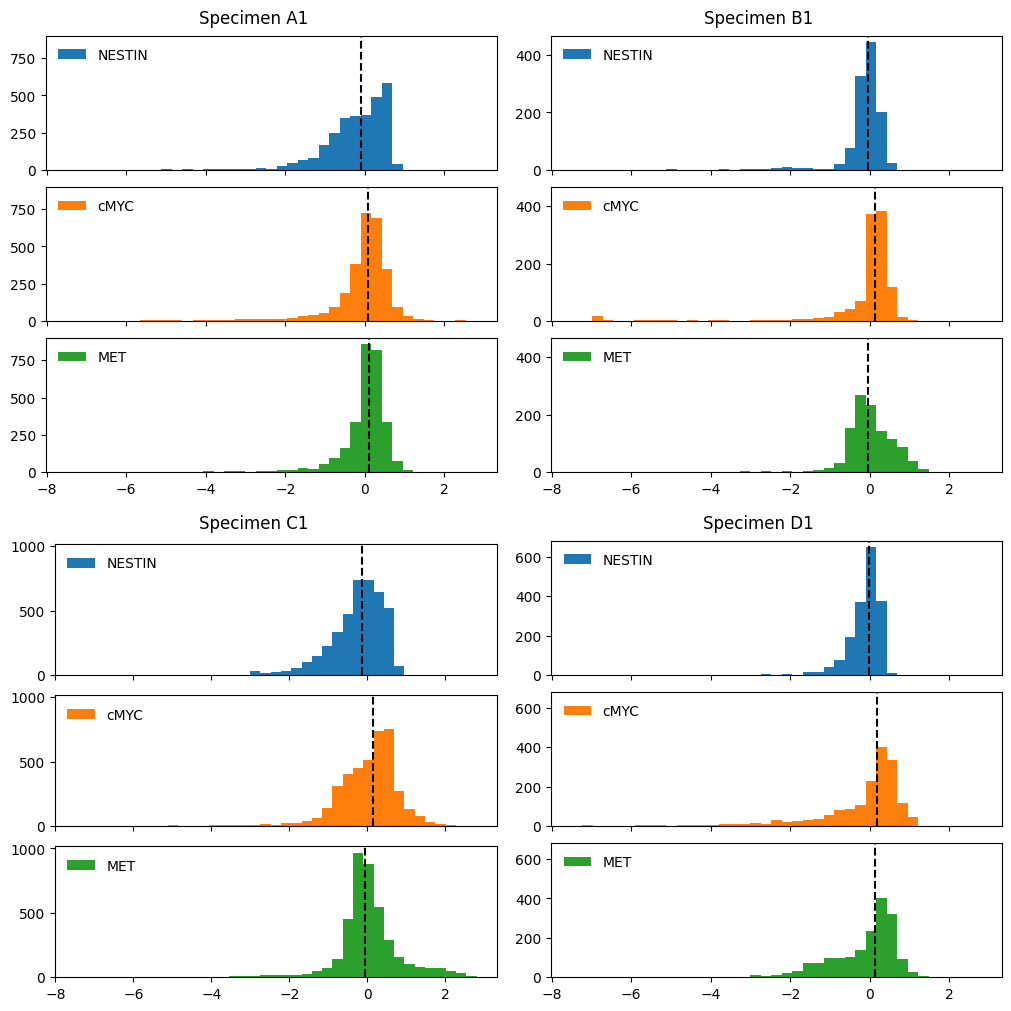

In [7]:
specimen_ids = df["specimen_id"].unique()
proteins_to_plot = ["NESTIN", "cMYC", "MET"]
num_bins = 30

# xbounds = (df[proteins_to_plot].min().min(), df[proteins_to_plot].max().max())
xbounds = (-7.5, 2.8)
bins = np.linspace(*xbounds, 40, endpoint=True)

fig = plt.figure(figsize=(10,10), layout="constrained")
subfigs = fig.subfigures(2,2)
for i, specimen_id in enumerate(specimen_ids):
    subfig = subfigs[i//2, i%2]
    axs = subfig.subplots(3, 1, sharex=True)
    df_specimen = df[df["specimen_id"]==specimen_id]
    for j, protein in enumerate(proteins_to_plot):
        axs[j].hist(df_specimen[protein], bins=bins, label=protein, color=f"C{j}")
        axs[j].legend(frameon=False, loc="upper left")
        axs[j].axvline(df_specimen[protein].median(), color="k", linestyle="--")
    subfig.suptitle(f"Specimen {specimen_id}")


for subfig in subfigs.flatten():
    lims = []
    for ax in subfig.get_axes():
        lims.append(ax.get_ylim())
    lims = list(zip(*lims))
    ybounds = (min(lims[0]), max(lims[1]))
    for ax in subfig.get_axes():
        ax.set_ylim(ybounds)
#

plt.show()

The distributions of the different proteins is broadly similar across the different specimens. The medians are all very close to 0 which is ideal as this suggests the data is already normalised. We will compare the distributions of each protein individually:
- NESTIN: B1 and D1 both have similar distributions with a smaller variance. A1 and C1 are similar with a larger variance and bigger left tail
- cMYC: B1 and D1 are again visually similar. A1 is more similar to these than to C1
- MET: All 4 distributions are quite varied.

### iii

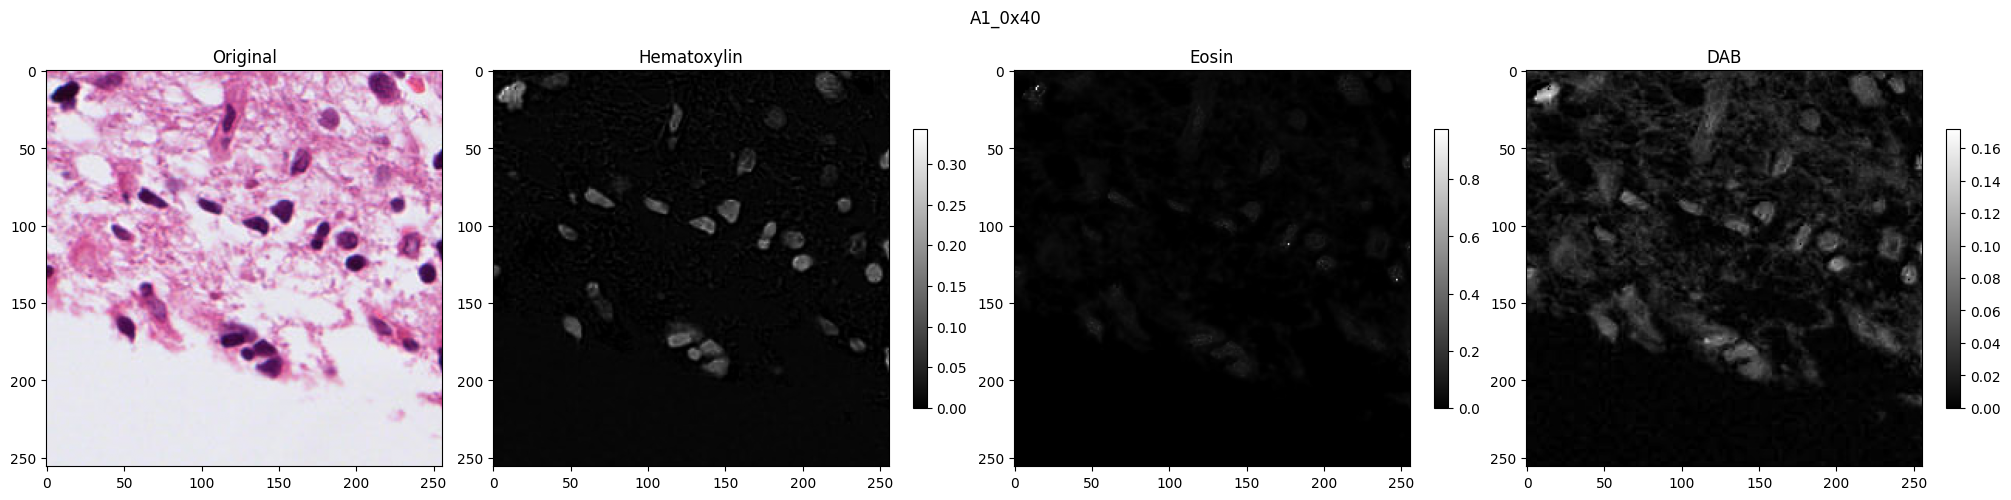

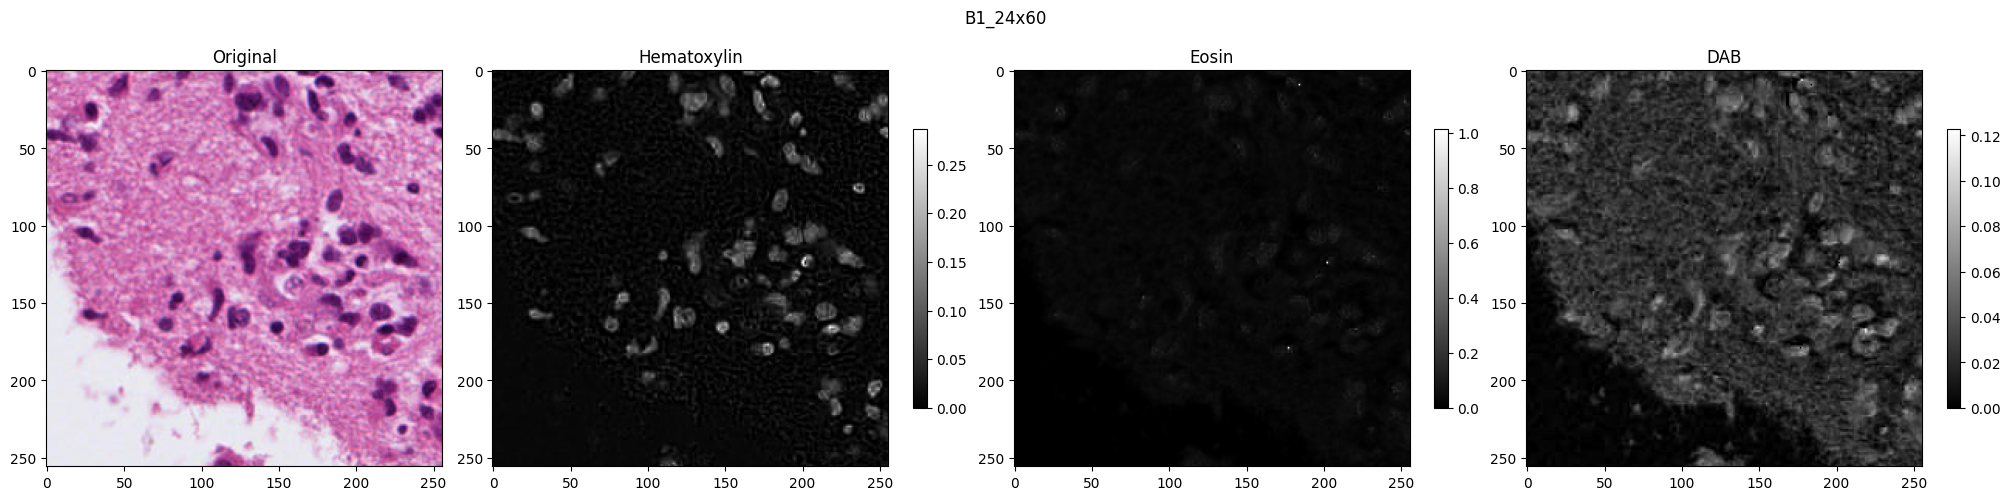

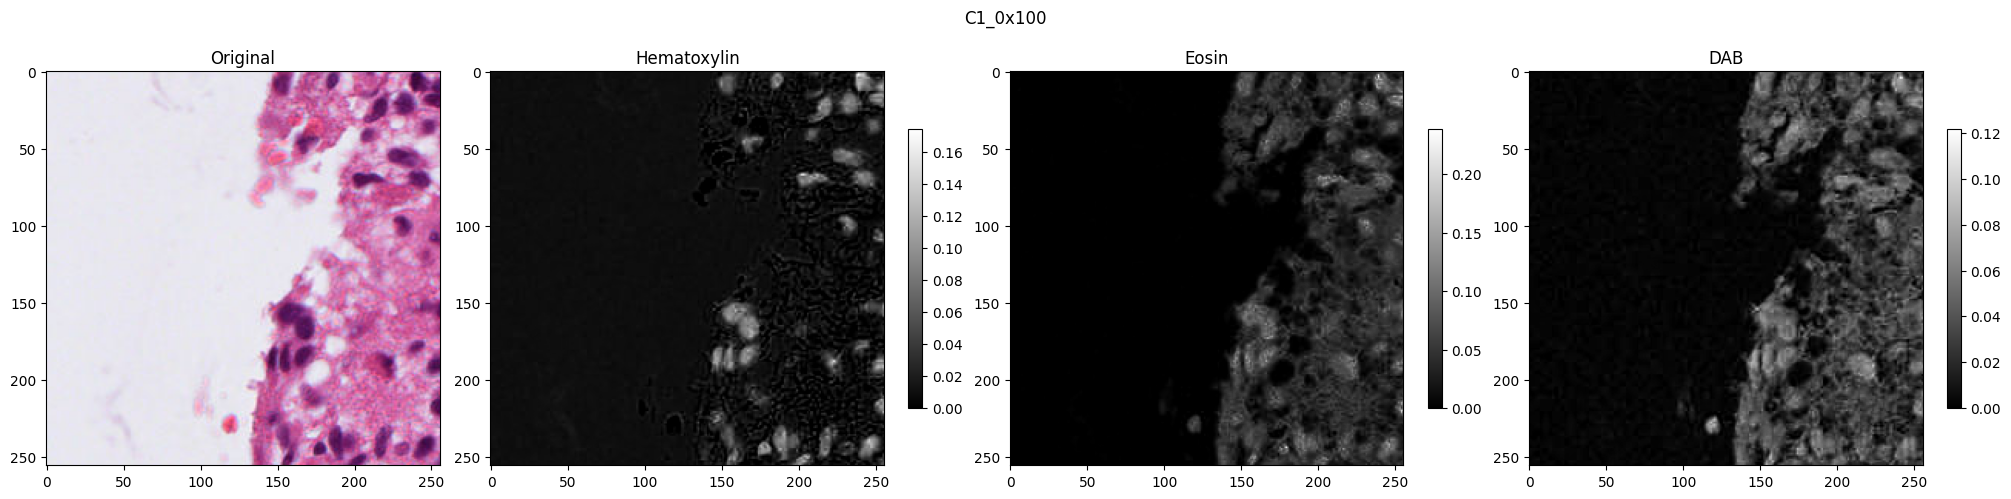

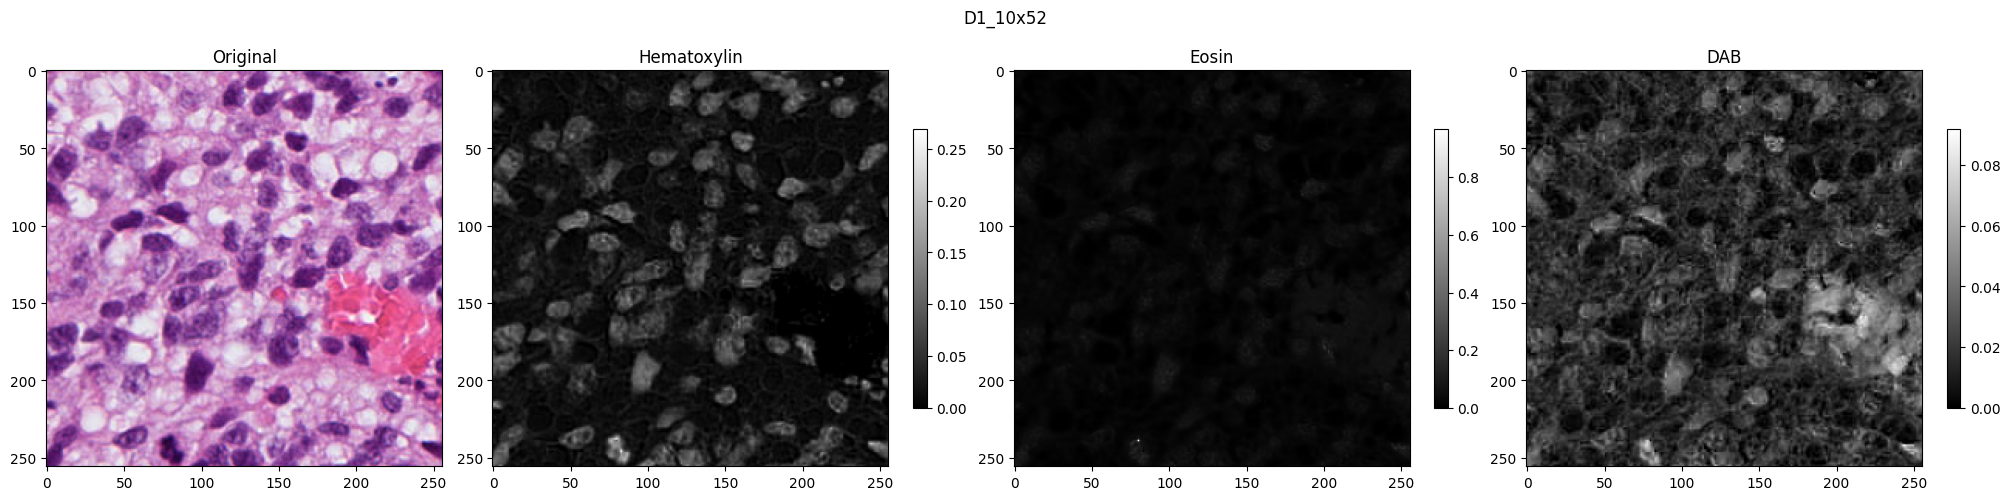

In [8]:
def load_image(image_id, image_folder=IMAGE_FOLDER):
    image_path = Path(image_folder) / f"{image_id}.png"
    im = imread(image_path)
    if im.shape[-1] == 4:
        im = rgba2rgb(im)
    return im

def show_image(image_id, image_folder=IMAGE_FOLDER, show_hed=False):
    if not show_hed:
        im = load_image(image_id, image_folder)
        plt.imshow(im)
        plt.title(image_id)
        plt.show()
    else:
        im = load_image(image_id, image_folder)
        im_hed = rgb2hed(im)
        fig, axs = plt.subplots(1, 4, figsize=(20, 5), layout="constrained")
        axs[0].imshow(im)
        axs[0].set_title("Original")
        for i, channel in enumerate(["Hematoxylin", "Eosin", "DAB"]):
            imshow = axs[i+1].imshow(im_hed[:, :, i], cmap="gray")
            axs[i+1].set_title(channel)
            fig.colorbar(imshow, ax=axs[i+1], shrink=0.6)
        fig.suptitle(image_id)
        plt.show()

np.random.seed(42)
for specimen_id in specimen_ids:
    image_ids = df[df["specimen_id"]==specimen_id].index
    show_image(image_ids[0], show_hed=True)

### iv

In [9]:
load_df: pd.DataFrame = get_checkpoint("df", "with_hematoxylin")
if load_df is not None:
    df = load_df
else:
    h_channel = []
    for image_id in tqdm(df.index):
        im = load_image(image_id)
        im_hed = rgb2hed(im)
        h_channel.append(im_hed[:, :, 0].mean())
    df["Hematoxylin"] = h_channel
    make_checkpoint(df, "df", "with_hematoxylin")

Loading checkpoint from checkpoints/df/with_hematoxylin.pkl


Text(0.5, 1.0, 'H-channel mean intensity vs NESTIN expression per image')

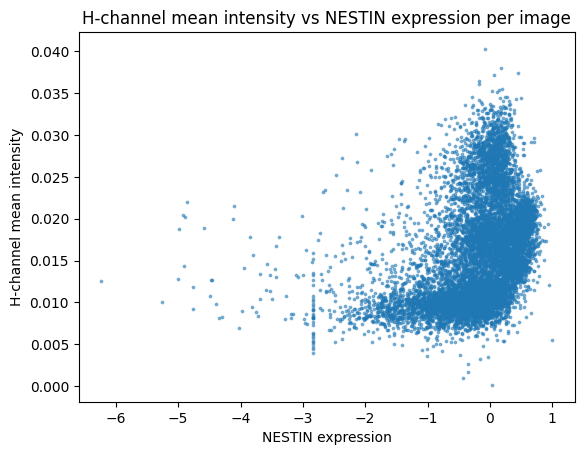

In [10]:
fig, ax = plt.subplots()
ax.scatter(df["NESTIN"], df["Hematoxylin"], alpha=0.5, s=3)
ax.set_xlabel("NESTIN expression")
ax.set_ylabel("H-channel mean intensity")
ax.set_title("H-channel mean intensity vs NESTIN expression per image")

We find the Spearman correlation coefficient for this data since it can tell us about non-linear monotonic correlation

In [11]:
df["NESTIN"].corr(df["Hematoxylin"], method="spearman")

0.45924540707372247

This tells us that there is a weak positive correlation in the data. This suggests that the average H-channel intensity could be useful but not sufficient in predicting the expression of NESTIN.

### v

Since we are trying to solve a regression problem and our target data is continuous, we should use MSE or RMSE as a performance metric. In our case, we will use MSE.

## Question 2

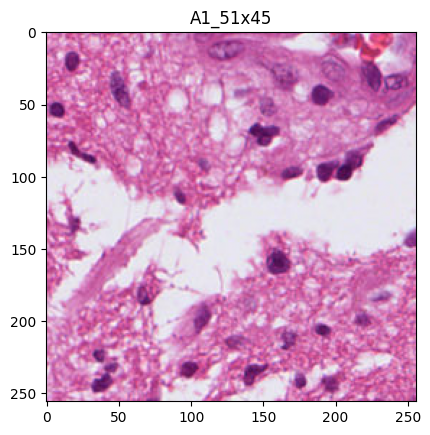

{'H_mean': 0.012282441136785784,
 'H_var': 0.0001939468458588533,
 'R_mean': 0.8199176264741971,
 'G_mean': 0.5597430060890856,
 'B_mean': 0.747364178825668,
 'R_var': 0.012255187318134011,
 'G_var': 0.049497199184893106,
 'B_var': 0.01901449286985428}

In [12]:
test_df = df[df["specimen_id"] == "C1"]
train_df = df[df["specimen_id"] != "C1"]

sample_image_data = train_df.sample(random_state=42)
sample_image_id = sample_image_data.index[0]

show_image(sample_image_id)

sample_image = load_image(sample_image_id)
sample_image_hed = rgb2hed(sample_image)

features = {}
means = sample_image_hed[:, :, 0].mean(), *sample_image.mean(axis=(0, 1))
vars = sample_image_hed[:, :, 0].var(), *sample_image.var(axis=(0, 1))

features = features | {
    "H_mean": means[0],
    "H_var": vars[0],
    "R_mean": means[1],
    "G_mean": means[2],
    "B_mean": means[3],
    "R_var": vars[1],
    "G_var": vars[2],
    "B_var": vars[3],
}
features

In [13]:
def downsample_image(im, factor: int = 4):
    return downscale_local_mean(im, (factor, factor, 1))

im_downsampled = downsample_image(sample_image)

load_downsampled_train_images = get_checkpoint("downsampled_train_images", "factor_4")
if load_downsampled_train_images is not None:
    downsampled_train_images = load_downsampled_train_images
else:
    downsampled_train_images = [downsample_image(load_image(image_id)) for image_id in tqdm(train_df.index)]
    make_checkpoint(downsampled_train_images, "downsampled_train_images", "factor_4")

Loading checkpoint from checkpoints/downsampled_train_images/factor_4.pkl


In [14]:
pca = PCA(n_components=32)
pca.fit(np.array(downsampled_train_images).reshape(-1, downsampled_train_images[0].size))

PCA(n_components=32)

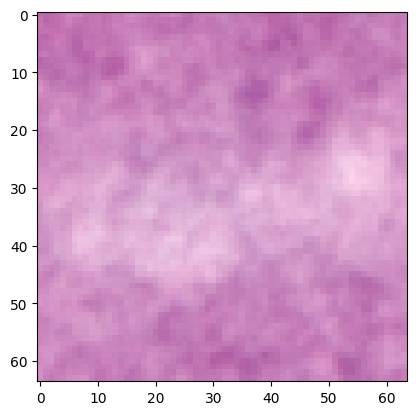

In [15]:
im_downsampled_pca = pca.transform(im_downsampled.reshape(1, -1))
inversed_pca = pca.inverse_transform(im_downsampled_pca).reshape(im_downsampled.shape)
plt.imshow(inversed_pca)

In [16]:
from scipy.special import expit
def get_features(im, pca, pca_dims: int=128):
    if pca_dims > pca.n_components:
        pca_dims = pca.n_components
        
    # HRGB features
    im_hed = rgb2hed(im)
    means = im_hed[:, :, 0].mean(), *im.mean(axis=(0, 1))
    vars = im_hed[:, :, 0].var(), *im.var(axis=(0, 1))
    features = {
        "H_mean": means[0],
        "H_var": vars[0],
        "R_mean": means[1],
        "G_mean": means[2],
        "B_mean": means[3],
        "R_var": vars[1],
        "G_var": vars[2],
        "B_var": vars[3],
    }
    
    # GLCM features
    glcm_h = graycomatrix(img_as_ubyte(expit(im_hed[:, :, 0])), [1], [0], 256, symmetric=True, normed=True)
    props = ["contrast", "dissimilarity", "homogeneity", "ASM", "energy", "correlation"]
    glcm_features = {f"H_{prop}": graycoprops(glcm_h, prop)[0, 0] for prop in props}
    
    # PCA features
    im_downsampled = downsample_image(im)
    pca_features = {f"PCA_{i}": pc for i, pc in enumerate(pca.transform(im_downsampled.reshape(1, -1))[0][:pca_dims])}
    
    features = features | glcm_features | pca_features
    return features

get_features(sample_image, pca, 32)

{'H_mean': 0.012282441136785784,
 'H_var': 0.0001939468458588533,
 'R_mean': 0.8199176264741971,
 'G_mean': 0.5597430060890856,
 'B_mean': 0.747364178825668,
 'R_var': 0.012255187318134011,
 'G_var': 0.049497199184893106,
 'B_var': 0.01901449286985428,
 'H_contrast': 0.22765012254901962,
 'H_dissimilarity': 0.18169424019607844,
 'H_homogeneity': 0.9136186114373289,
 'H_ASM': 0.5684480970266093,
 'H_energy': 0.7539549701584367,
 'H_correlation': 0.846401395426819,
 'PCA_0': -5962.521947445816,
 'PCA_1': 36.07611198478645,
 'PCA_2': -2.8626067723450888,
 'PCA_3': -0.10883433734407078,
 'PCA_4': 4.652719495555175,
 'PCA_5': 1.555923571586419,
 'PCA_6': -3.109302076882244,
 'PCA_7': 0.5176443297973492,
 'PCA_8': -2.0747541378897267,
 'PCA_9': -0.7549523135241998,
 'PCA_10': -0.020736873774453102,
 'PCA_11': -0.26766344959072974,
 'PCA_12': -1.117920462812088,
 'PCA_13': -1.619039648279994,
 'PCA_14': 0.5332568064110887,
 'PCA_15': -1.1725664159090883,
 'PCA_16': 0.2026718068104003,
 'PCA_1

In [17]:
load_train_features = get_checkpoint("train_features", "hrgb_glcmh_pca32")
if load_train_features is not None:
    train_features = load_train_features
else:
    train_features = [get_features(load_image(image_id), pca) for image_id in tqdm(train_df.index)]
    train_features = pd.DataFrame(train_features, index=train_df.index)
    make_checkpoint(train_features, "train_features", "hrgb_glcmh_pca32", overwrite=True)
    
load_test_features = get_checkpoint("test_features", "hrgb_glcmh_pca32")
if load_test_features is not None:
    test_features = load_test_features
else:
    test_features = [get_features(load_image(image_id), pca) for image_id in tqdm(test_df.index)]
    test_features = pd.DataFrame(test_features, index=test_df.index)
    make_checkpoint(test_features, "test_features", "hrgb_glcmh_pca32", overwrite=True)

Loading checkpoint from checkpoints/train_features/hrgb_glcmh_pca32.pkl
Loading checkpoint from checkpoints/test_features/hrgb_glcmh_pca32.pkl


In [18]:
feature_correlations = {i: train_df["NESTIN"].corr(train_features[i], method="spearman") for i in train_features.columns}
{k: v for k, v in sorted(feature_correlations.items(), key=lambda item: abs(item[1]), reverse=True)}

{'H_ASM': -0.4671361938138026,
 'H_energy': -0.4671361938138026,
 'H_homogeneity': -0.4061255312421966,
 'R_mean': -0.39739477446527177,
 'H_mean': 0.3896892806400213,
 'H_dissimilarity': 0.3857671149136957,
 'H_contrast': 0.3124543253299608,
 'PCA_0': -0.311532418316924,
 'PCA_1': -0.2763761719625959,
 'G_mean': -0.25470833451264996,
 'H_var': 0.24373747133610882,
 'B_mean': -0.22365551232583922,
 'R_var': 0.19739780381055974,
 'PCA_14': -0.08284609658754744,
 'PCA_29': -0.0749989820620195,
 'PCA_12': 0.06759314833849164,
 'PCA_28': -0.05751403146596507,
 'PCA_22': -0.0557759011599916,
 'PCA_18': -0.052352108702702314,
 'PCA_27': -0.04766257923339692,
 'H_correlation': 0.04595877643493582,
 'PCA_17': -0.037957441520062696,
 'PCA_21': -0.03470681172249004,
 'PCA_13': -0.034625281885002177,
 'PCA_23': 0.03346941480888392,
 'PCA_26': 0.029878566479847577,
 'PCA_6': 0.02541942531671927,
 'PCA_15': -0.02215628914692749,
 'PCA_4': 0.01948621446710004,
 'PCA_30': 0.018223248181156056,
 'PCA_

As we can see, the GLCM features for the H channel have some correlation with the expression of nestin, as do the mean and variances of the H, R, G, B values. The first two PCs also have a decent correlation with the others being much less important. We will thus use only the first two components

In [19]:
cols_to_drop = [col for col in train_features.columns if "PCA" in col and col not in {"PCA_0", "PCA_1"}]
train_features = train_features.drop(columns=cols_to_drop)
test_features = test_features.drop(columns=cols_to_drop)

In [20]:
import torch
from torchvision.ops import MLP

class ProteinDataset(torch.utils.data.Dataset):
    def __init__(self, features, labels, device="cpu"):
        self.features = features
        self.labels = labels
        assert self.features.shape[0] == self.labels.shape[0]
        self.features = torch.tensor(self.features, dtype=torch.float32, device=device)
        self.labels = torch.tensor(self.labels, dtype=torch.float32, device=device)[:, None]
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [21]:
def train_one_epoch(model, optimizer, loss_fn, train_dataloader: torch.utils.data.DataLoader, print_every: int | None =50):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(train_dataloader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if print_every is not None:
            if i % print_every == print_every - 1:
                last_loss = running_loss / print_every # loss per batch
                print('  batch {} loss: {}'.format(i + 1, last_loss))
                running_loss = 0.
        else:
            last_loss = running_loss / (i + 1)

    return last_loss

Here we define our MLP training process. The MLP itself is very small with only one hidden layer of size 32. It uses LeakyReLU activation functions which have the added benefit over ReLU functions of not 'zeroing out'.

In [22]:
from sklearn.preprocessing import StandardScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_val_split = 0.8
hidden_dims = [32]

feature_scaler = StandardScaler()
label_scaler = StandardScaler()

train_labels = train_df["NESTIN"].values.reshape(-1, 1)
test_labels = test_df["NESTIN"].values.reshape(-1, 1)

feature_scaler.fit(train_features)
label_scaler.fit(train_labels)

nontest_features_scaled = feature_scaler.transform(train_features)
test_features_scaled = feature_scaler.transform(test_features)
nontest_labels_scaled = label_scaler.transform(train_labels).squeeze()
test_labels_scaled = label_scaler.transform(test_labels).squeeze()

print(nontest_features_scaled.shape, nontest_labels_scaled.shape)

nontest_dataset = ProteinDataset(nontest_features_scaled, nontest_labels_scaled, device=device)
test_dataset = ProteinDataset(test_features_scaled, test_labels_scaled, device=device)
train_dataset, val_dataset = torch.utils.data.random_split(nontest_dataset, [int(train_val_split*len(nontest_dataset)), len(nontest_dataset)-int(train_val_split*len(nontest_dataset))])
train_dataloader, val_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True), torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

model = MLP(train_features.shape[1], hidden_dims + [1], dropout=0.2, activation_layer=torch.nn.LeakyReLU).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 200, 350, 500], gamma=0.5)
loss_fn = torch.nn.MSELoss()

best_vloss = np.infty
best_weights = None

(5792, 16) (5792,)


In [23]:
def run_mlp_train(epochs: int = 1500):
    print("Training with dataset of size", len(train_dataset))
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}, lr={optimizer.param_groups[0]['lr']:.2e}")
        model.train(True)
        avg_loss = train_one_epoch(model, optimizer, loss_fn, train_dataloader)
        
        running_vloss = 0.0
        model.eval()
        with torch.no_grad():
            for i, vdata in enumerate(val_dataloader):
                vinputs, vlabels = vdata
                voutputs = model(vinputs)
                vloss = loss_fn(voutputs, vlabels)
                running_vloss += vloss
        avg_vloss = running_vloss / (i + 1)
        if avg_vloss < best_vloss:
            print(f"Saving best parameters for model with validation loss {avg_vloss:.5f}...")
            best_weights = dict(model.state_dict())
            best_vloss = avg_vloss
        if avg_vloss > 3 * best_vloss:
            print(f"High vloss, loading old weights")
            model.load_state_dict(best_weights)
        
        print(f"LOSS train {avg_loss:.5f} valid {avg_vloss:.5f}")
        
        scheduler.step()
    else:
        print("Training finished")
        print(f"Best validation loss: {best_vloss:.5f}")
        model.load_state_dict(best_weights)
        make_checkpoint(model, "mlp", "nestin_regression", overwrite=True)
        
# run_mlp_train(epochs=1500)
    

In [24]:
load_model = get_checkpoint("mlp", "nestin_regression")
model = load_model.to(device) if load_model is not None else model
model.eval()
with torch.no_grad():
    for i, vdata in enumerate(train_dataloader):
        vinputs, vlabels = vdata
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        print(f"output: {voutputs[0].item():.4f}, label: {vlabels[0].item():.2f}, loss: {vloss.item():.2f}")

Loading checkpoint from checkpoints/mlp/nestin_regression.pkl
output: 0.1448, label: 0.13, loss: 1.04
output: 0.2943, label: 1.22, loss: 0.92
output: 0.4876, label: 0.63, loss: 0.37
output: 0.2838, label: 0.38, loss: 0.78
output: -0.7843, label: -0.95, loss: 0.25
output: 0.0863, label: -0.66, loss: 0.43
output: -0.1679, label: 0.04, loss: 0.73
output: 0.0660, label: -0.12, loss: 0.39
output: 0.2018, label: 0.47, loss: 0.43
output: 0.0966, label: -0.21, loss: 0.36
output: 0.2390, label: 0.57, loss: 0.29
output: 0.2748, label: 0.58, loss: 0.30
output: 0.3898, label: 0.86, loss: 0.30
output: 0.2565, label: 0.53, loss: 0.26
output: 0.2269, label: 0.34, loss: 0.57
output: 0.2517, label: 0.18, loss: 0.18
output: -0.1070, label: 0.31, loss: 0.88
output: 0.0325, label: 0.13, loss: 0.42
output: 0.1629, label: 0.75, loss: 0.40
output: -1.3580, label: -2.38, loss: 0.31
output: 0.3396, label: 0.41, loss: 0.38
output: 0.0643, label: 0.38, loss: 0.36
output: -0.1268, label: 0.01, loss: 0.30
output: 

In [25]:
def dataset_to_features_labels(dataset: torch.utils.data.Dataset):
    train_dataset_raw: list[torch.Tensor] = train_dataset[:]
    return (train_dataset_raw[0].cpu().numpy(), 
            train_dataset_raw[1].cpu().numpy().squeeze())


In [26]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import root_mean_squared_error, r2_score
from scipy.stats import spearmanr, pearsonr

In [27]:
train_dataset_features, train_dataset_labels = dataset_to_features_labels(nontest_dataset)

param_grid = {"C": [0.01, 0.1, 1, 10, 100]}
svr = SVR()

reg = GridSearchCV(svr, param_grid, cv=3, n_jobs=-1, verbose=2, scoring="neg_mean_squared_error")
reg.fit(train_dataset_features, train_dataset_labels)
print(reg.best_params_)
print(reg.best_score_)


Fitting 3 folds for each of 5 candidates, totalling 15 fits


[CV] END ..............................................C=0.1; total time=   0.9s
[CV] END ................................................C=1; total time=   0.9s
[CV] END ..............................................C=0.1; total time=   1.0s
[CV] END ................................................C=1; total time=   1.0s
[CV] END ................................................C=1; total time=   0.9s
[CV] END .............................................C=0.01; total time=   1.1s
[CV] END .............................................C=0.01; total time=   1.1s
[CV] END .............................................C=0.01; total time=   1.1s
[CV] END ..............................................C=0.1; total time=   1.0s
[CV] END ...............................................C=10; total time=   1.0s
[CV] END ...............................................C=10; total time=   1.0s
[CV] END ...............................................C=10; total time=   1.0s
[CV] END ...................

In [28]:
def get_regression_metrics(predicted, labels):
    rmse = root_mean_squared_error(labels, predicted)
    pearson = pearsonr(labels.squeeze(), predicted.squeeze())[0]
    spearman = spearmanr(labels.squeeze(), predicted.squeeze())[0]
    r2 = r2_score(labels, predicted)
    return {"RMSE": rmse, "Pearson": pearson, "Spearman": spearman, "R2 score": r2}

def print_metrics(metrics):
    for k, v in metrics.items():
        print(f"  {k}: {v:.5f}")

In [29]:
test_dataset_features, test_dataset_labels = dataset_to_features_labels(test_dataset)
test_dataset_labels_unscaled = label_scaler.inverse_transform(test_dataset_labels.reshape(-1, 1))

svr_test_predictions = reg.predict(test_dataset_features)
svr_test_predictions = label_scaler.inverse_transform(svr_test_predictions.reshape(-1, 1))

with torch.no_grad():
    model.eval()
    mlp_test_predictions = model(torch.from_numpy(test_dataset_features).to(device)).cpu().numpy().squeeze()
    mlp_test_predictions = label_scaler.inverse_transform(mlp_test_predictions.reshape(-1, 1))

svr_metrics = get_regression_metrics(svr_test_predictions, test_dataset_labels_unscaled)
mlp_metrics = get_regression_metrics(mlp_test_predictions, test_dataset_labels_unscaled)

SVR metrics:
  RMSE: 0.44751
  Pearson: 0.74334
  Spearman: 0.77844
  R2 score: 0.54492


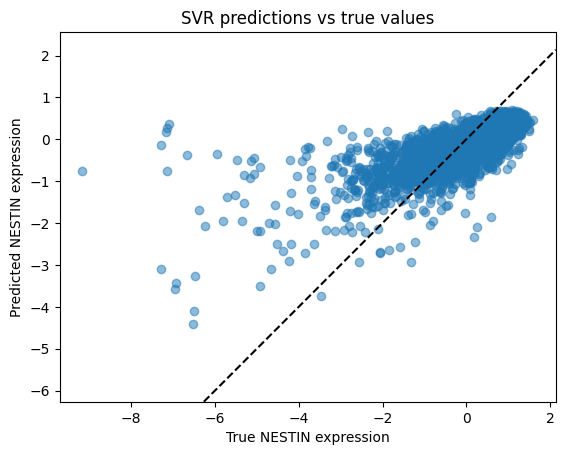

MLP metrics:
  RMSE: 0.49184
  Pearson: 0.69013
  Spearman: 0.69310
  R2 score: 0.45028


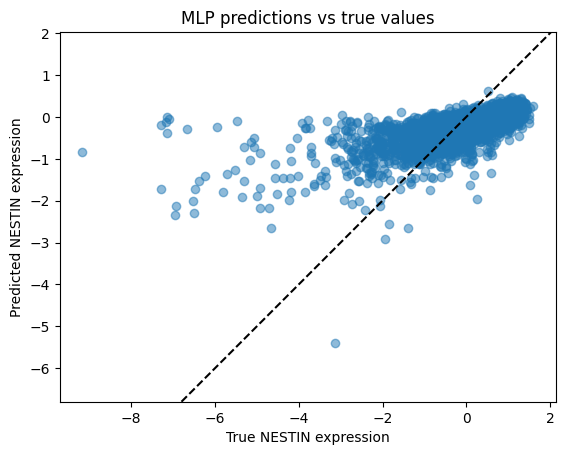

In [30]:
print("SVR metrics:")
print_metrics(svr_metrics)

plt.figure()
plt.scatter(test_dataset_labels, svr_test_predictions, alpha=0.5)
plt.title("SVR predictions vs true values")
plt.xlabel("True NESTIN expression")
plt.ylabel("Predicted NESTIN expression")
plt.axline((0, 0), slope=1, color="k", linestyle="--")
plt.axis("equal")
plt.show()

print("MLP metrics:")
print_metrics(mlp_metrics)

plt.figure()
plt.scatter(test_dataset_labels, mlp_test_predictions, alpha=0.5)
plt.title("MLP predictions vs true values")
plt.xlabel("True NESTIN expression")
plt.ylabel("Predicted NESTIN expression")
plt.axline((0, 0), slope=1, color="k", linestyle="--")
plt.axis("equal")
plt.show()

## Question 3
### i

In [31]:
import torchsummary

In [32]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, df: pd.DataFrame, label_columns: list[str] = ["NESTIN"], image_folder=IMAGE_FOLDER, device="cpu", load_all=False):
        self.image_folder = image_folder
        self.image_ids = df.index
        self.label_columns = label_columns
        self.labels = df[label_columns].values
        self.device = device
        self.load_all = load_all
        self.images = None
        if load_all:
            print("Loading all images...")
            self.images = [torch.tensor(load_image(image_id, image_folder), dtype=torch.float32, device=device).permute(2, 0, 1) for image_id in tqdm(self.image_ids)]
        
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        if self.load_all:
            im = self.images[idx]
        else:
            im = load_image(self.image_ids[idx], self.image_folder)
            im = torch.tensor(im, dtype=torch.float32, device=self.device).permute(2, 0, 1)
        labels = torch.tensor(self.labels[idx], dtype=torch.float32, device=self.device)
        return im, labels
    
    def clear_images(self):
        if self.images is not None:
            for t in self.images:
                t.detach()
                t.grad = None
                t.untyped_storage().resize_(0)
                del t
                
            torch.cuda.empty_cache()

In [33]:
def run_conv_train(epochs: int = 500, train_val_split = 0.85):

    nontest_image_dataset = ImageDataset(train_df, device=device, load_all=True)
    train_image_dataset, val_image_dataset = torch.utils.data.random_split(nontest_image_dataset, 
                                                                        [int(train_val_split*len(nontest_dataset)), 
                                                                            len(nontest_dataset)-int(train_val_split*len(nontest_dataset))]
                                                                        )

    train_image_dataloader = torch.utils.data.DataLoader(train_image_dataset, batch_size=32, shuffle=True)
    val_image_dataloader = torch.utils.data.DataLoader(val_image_dataset, batch_size=32, shuffle=False)

    # plt.figure()
    # plt.title(f"Example image from dataset: {nontest_image_dataset.image_ids[0]}")
    # plt.imshow(nontest_image_dataset[0][0].permute(1,2,0).cpu())

    convnet = torch.nn.Sequential(
        torch.nn.Conv2d(3, 16, kernel_size=3, stride=4, padding=1),
        torch.nn.LeakyReLU(),
        torch.nn.MaxPool2d(2),
        torch.nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
        torch.nn.LeakyReLU(),
        torch.nn.MaxPool2d(2),
        torch.nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
        torch.nn.LeakyReLU(),
        torch.nn.MaxPool2d(2),
        torch.nn.Flatten(),
        torch.nn.Dropout(0.2),
        torch.nn.Linear(16*4*4, 1)
    ).to(device)
    torchsummary.summary(convnet, (3, 256, 256))

    conv_optimizer = torch.optim.Adam(convnet.parameters(), lr=0.001)
    conv_scheduler = torch.optim.lr_scheduler.MultiStepLR(conv_optimizer, milestones=[200, 400], gamma=0.5)
    loss_fn = torch.nn.MSELoss()

    load_best_convnet_vloss = get_checkpoint("convnetloss", "nestin_regression")
    best_convnet_vloss = np.infty if load_best_convnet_vloss is None else load_best_convnet_vloss
    print("Training with dataset of size", len(train_image_dataset))
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}, lr={conv_optimizer.param_groups[0]['lr']:.2e}")
        convnet.train(True)
        avg_loss = train_one_epoch(convnet, conv_optimizer, loss_fn, train_image_dataloader, print_every=40)
        
        running_vloss = 0.0
        convnet.eval()
        with torch.no_grad():
            for i, vdata in enumerate(val_image_dataloader):
                vinputs, vlabels = vdata
                voutputs = convnet(vinputs)
                vloss = loss_fn(voutputs, vlabels)
                running_vloss += vloss
        avg_vloss = running_vloss / (i + 1)
        if avg_vloss < best_convnet_vloss:
            best_convnet_vloss = avg_vloss
            print(f"Saving best parameters for model with validation loss {avg_vloss:.5f}...")
            make_checkpoint(convnet, "convnet", "nestin_regression", overwrite=True)
            make_checkpoint(optimizer, "convopt", "nestin_regression", overwrite=True)
            make_checkpoint(best_convnet_vloss, "convnetloss", "nestin_regression", overwrite=True)

        print(f"LOSS train {avg_loss:.5f} valid {avg_vloss:.5f}")
        
        conv_scheduler.step()
    else:
        print("Training finished")
        print(f"Best validation loss: {best_convnet_vloss:.5f}")
    nontest_image_dataset.clear_images()
    del nontest_image_dataset
        
# run_conv_train(epochs=500)

I found that a very small CNN with using a small number of filters, large strides and many pooling layers worked best as it converged quickly and the problem was relatively very simple. There were many iterations of the architecture but this was the best RMSE result.

In [34]:
convnet = get_checkpoint("convnet", "nestin_regression")

test_image_dataset = ImageDataset(test_df, device=device)
test_image_dataloader = torch.utils.data.DataLoader(test_image_dataset, batch_size=32, shuffle=False)
predicted_labels = []
true_labels = []
with torch.no_grad():
    convnet.eval()
    for i, data in tqdm(enumerate(test_image_dataloader), total=len(test_image_dataloader)):
        inputs, labels = data
        outputs = convnet(inputs)
        predicted_labels.append(outputs.cpu().numpy())
        true_labels.append(labels.cpu().numpy())
predicted_labels = np.concatenate(predicted_labels)
true_labels = np.concatenate(true_labels)

predicted_labels_unscaled = label_scaler.inverse_transform(predicted_labels)
true_labels_unscaled = label_scaler.inverse_transform(true_labels)

Loading checkpoint from checkpoints/convnet/nestin_regression.pkl


100%|██████████| 130/130 [00:15<00:00,  8.21it/s]


In [35]:
convnet_metrics = get_regression_metrics(predicted_labels_unscaled, true_labels_unscaled)

Convoluted neural network metrics:
  RMSE: 0.46982
  Pearson: 0.05245
  Spearman: -0.02678
  R2 score: -0.15737


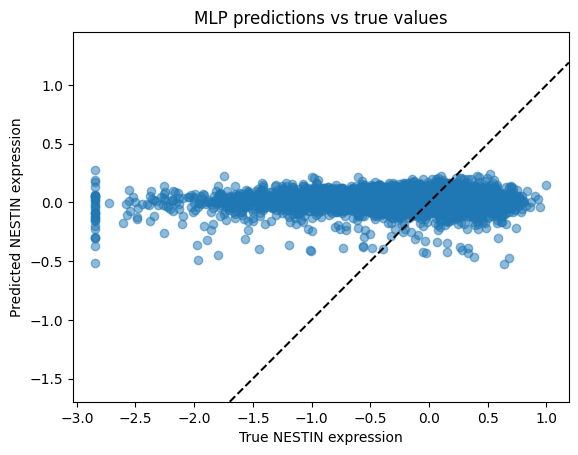

In [36]:
print("Convoluted neural network metrics:")
print_metrics(convnet_metrics)

plt.figure()
plt.scatter(true_labels, predicted_labels, alpha=0.5)
plt.title("MLP predictions vs true values")
plt.xlabel("True NESTIN expression")
plt.ylabel("Predicted NESTIN expression")
plt.axline((0, 0), slope=1, color="k", linestyle="--")
plt.axis("equal")
plt.show()

In [39]:
def Group4Split(df, group_column="specimen_id"):
    """Get indices for GroupKFold cross-validation."""
    specimen_ids = df[group_column].unique()
    np.random.shuffle(specimen_ids)
    assert len(specimen_ids) == 4
    for i in range(4):
        test_specimen = specimen_ids[i]
        train_specimens = np.setdiff1d(specimen_ids, test_specimen)
        test_indices = np.where(df[group_column] == test_specimen)[0]
        train_indices = np.where(df[group_column].isin(train_specimens))[0]
        yield test_specimen, train_indices, test_indices

In [40]:
def get_conv_combine_model():
    convnetcombine = torch.nn.Sequential(
        torch.nn.Conv2d(3, 16, kernel_size=3, stride=4, padding=1),
        torch.nn.LeakyReLU(),
        torch.nn.MaxPool2d(2),
        torch.nn.BatchNorm2d(16),
        torch.nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
        torch.nn.LeakyReLU(),
        torch.nn.MaxPool2d(2),
        torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
        torch.nn.LeakyReLU(),
        torch.nn.MaxPool2d(2),
        torch.nn.Flatten(),
        torch.nn.Dropout(0.2),
        torch.nn.Linear(32*4*4, 5)
    ).to(device)
    return convnetcombine
torchsummary.summary(get_conv_combine_model(), (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]             448
         LeakyReLU-2           [-1, 16, 64, 64]               0
         MaxPool2d-3           [-1, 16, 32, 32]               0
       BatchNorm2d-4           [-1, 16, 32, 32]              32
            Conv2d-5           [-1, 16, 16, 16]           2,320
         LeakyReLU-6           [-1, 16, 16, 16]               0
         MaxPool2d-7             [-1, 16, 8, 8]               0
            Conv2d-8             [-1, 32, 8, 8]           4,640
         LeakyReLU-9             [-1, 32, 8, 8]               0
        MaxPool2d-10             [-1, 32, 4, 4]               0
          Flatten-11                  [-1, 512]               0
          Dropout-12                  [-1, 512]               0
           Linear-13                    [-1, 5]           2,565
Total params: 10,005
Trainable params: 

In [41]:
image_dataset = ImageDataset(df, label_columns=["EGFR", "PTEN", "NESTIN", "SOX2", "MET"], device=device, load_all=True)

Loading all images...


100%|██████████| 9921/9921 [00:48<00:00, 203.47it/s]


In [42]:
splits = list(Group4Split(df))

In [61]:
def run_4fold_cv(splits, epochs=10):
    load_best_convnet_vloss = get_checkpoint("best_4fold_vloss", "final")
    load_best_convnet_vloss = None
    best_convnet_vloss = (load_best_convnet_vloss if load_best_convnet_vloss is not None else 
                          {split[0]: np.infty for split in splits})

    for specimen_id, train_idxs, val_idxs in splits:
        train_image_dataset_split = torch.utils.data.Subset(image_dataset, train_idxs)
        val_image_dataset_split = torch.utils.data.Subset(image_dataset, val_idxs)
        
        train_image_dataloader = torch.utils.data.DataLoader(train_image_dataset_split, batch_size=32, shuffle=True)
        val_image_dataloader = torch.utils.data.DataLoader(val_image_dataset_split, batch_size=32, shuffle=False)
        
        convnetcombine = get_conv_combine_model()
        conv_optimizer = torch.optim.Adam(convnetcombine.parameters(), lr=0.001)
        conv_scheduler = torch.optim.lr_scheduler.MultiStepLR(conv_optimizer, milestones=[5], gamma=0.5)
        loss_fn = torch.nn.MSELoss()

        print("Training with dataset of size", len(image_dataset))
        for epoch in range(epochs):
            print(f"Epoch {epoch+1}, lr={conv_optimizer.param_groups[0]['lr']:.2e}")
            convnetcombine.train(True)
            avg_loss = train_one_epoch(convnetcombine, conv_optimizer, loss_fn, train_image_dataloader, print_every=40)
            
            running_vloss = 0.0
            convnetcombine.eval()
            with torch.no_grad():
                for i, vdata in enumerate(val_image_dataloader):
                    vinputs, vlabels = vdata
                    voutputs = convnetcombine(vinputs)
                    vloss = loss_fn(voutputs, vlabels)
                    running_vloss += vloss
            avg_vloss = running_vloss / (i + 1)
            if avg_vloss < best_convnet_vloss[specimen_id]:
                best_convnet_vloss[specimen_id] = avg_vloss
                print(f"Saving best parameters for model with validation loss {avg_vloss:.5f}...")
                make_checkpoint(convnetcombine, "convnetcombine", f"regression_spec_{specimen_id}", overwrite=True)
                make_checkpoint(optimizer, "convoptcombine", f"regression_spec_{specimen_id}", overwrite=True)
                make_checkpoint(best_convnet_vloss, "best_4fold_vloss", "final", overwrite=True)

            print(f"LOSS train {avg_loss:.5f} valid {avg_vloss:.5f}")
            
            conv_scheduler.step()
        else:
            print("Training finished")
            print(f"Best validation loss: {best_convnet_vloss}")

run_4fold_cv(splits, epochs=30)

Loading checkpoint from checkpoints/best_4fold_vloss/final.pkl
Training with dataset of size 9921
Epoch 1, lr=1.00e-03
  batch 40 loss: 0.7091795064508915
  batch 80 loss: 0.5808551520109176
  batch 120 loss: 0.6897335287183524
  batch 160 loss: 0.659008727222681
Saving best parameters for model with validation loss 0.81969...
Overwriting existing checkpoint.
Saving checkpoint to checkpoints/convnetcombine/regression_spec_C1.pkl
Overwriting existing checkpoint.
Saving checkpoint to checkpoints/convoptcombine/regression_spec_C1.pkl
Overwriting existing checkpoint.
Saving checkpoint to checkpoints/best_4fold_vloss/final.pkl
LOSS train 0.65901 valid 0.81969
Epoch 2, lr=1.00e-03
  batch 40 loss: 0.6474222548305988
  batch 80 loss: 0.6227252267301082
  batch 120 loss: 0.7021789476275444
  batch 160 loss: 0.605505071952939
Saving best parameters for model with validation loss 0.81555...
Overwriting existing checkpoint.
Saving checkpoint to checkpoints/convnetcombine/regression_spec_C1.pkl
Ov

Loading checkpoint from checkpoints/convnetcombine/regression_spec_C1.pkl
Loading checkpoint from checkpoints/convnetcombine/regression_spec_A1.pkl
Loading checkpoint from checkpoints/convnetcombine/regression_spec_B1.pkl
Loading checkpoint from checkpoints/convnetcombine/regression_spec_D1.pkl


Text(0.5, 0.98, 'Predicted vs true expression values for each specimen')

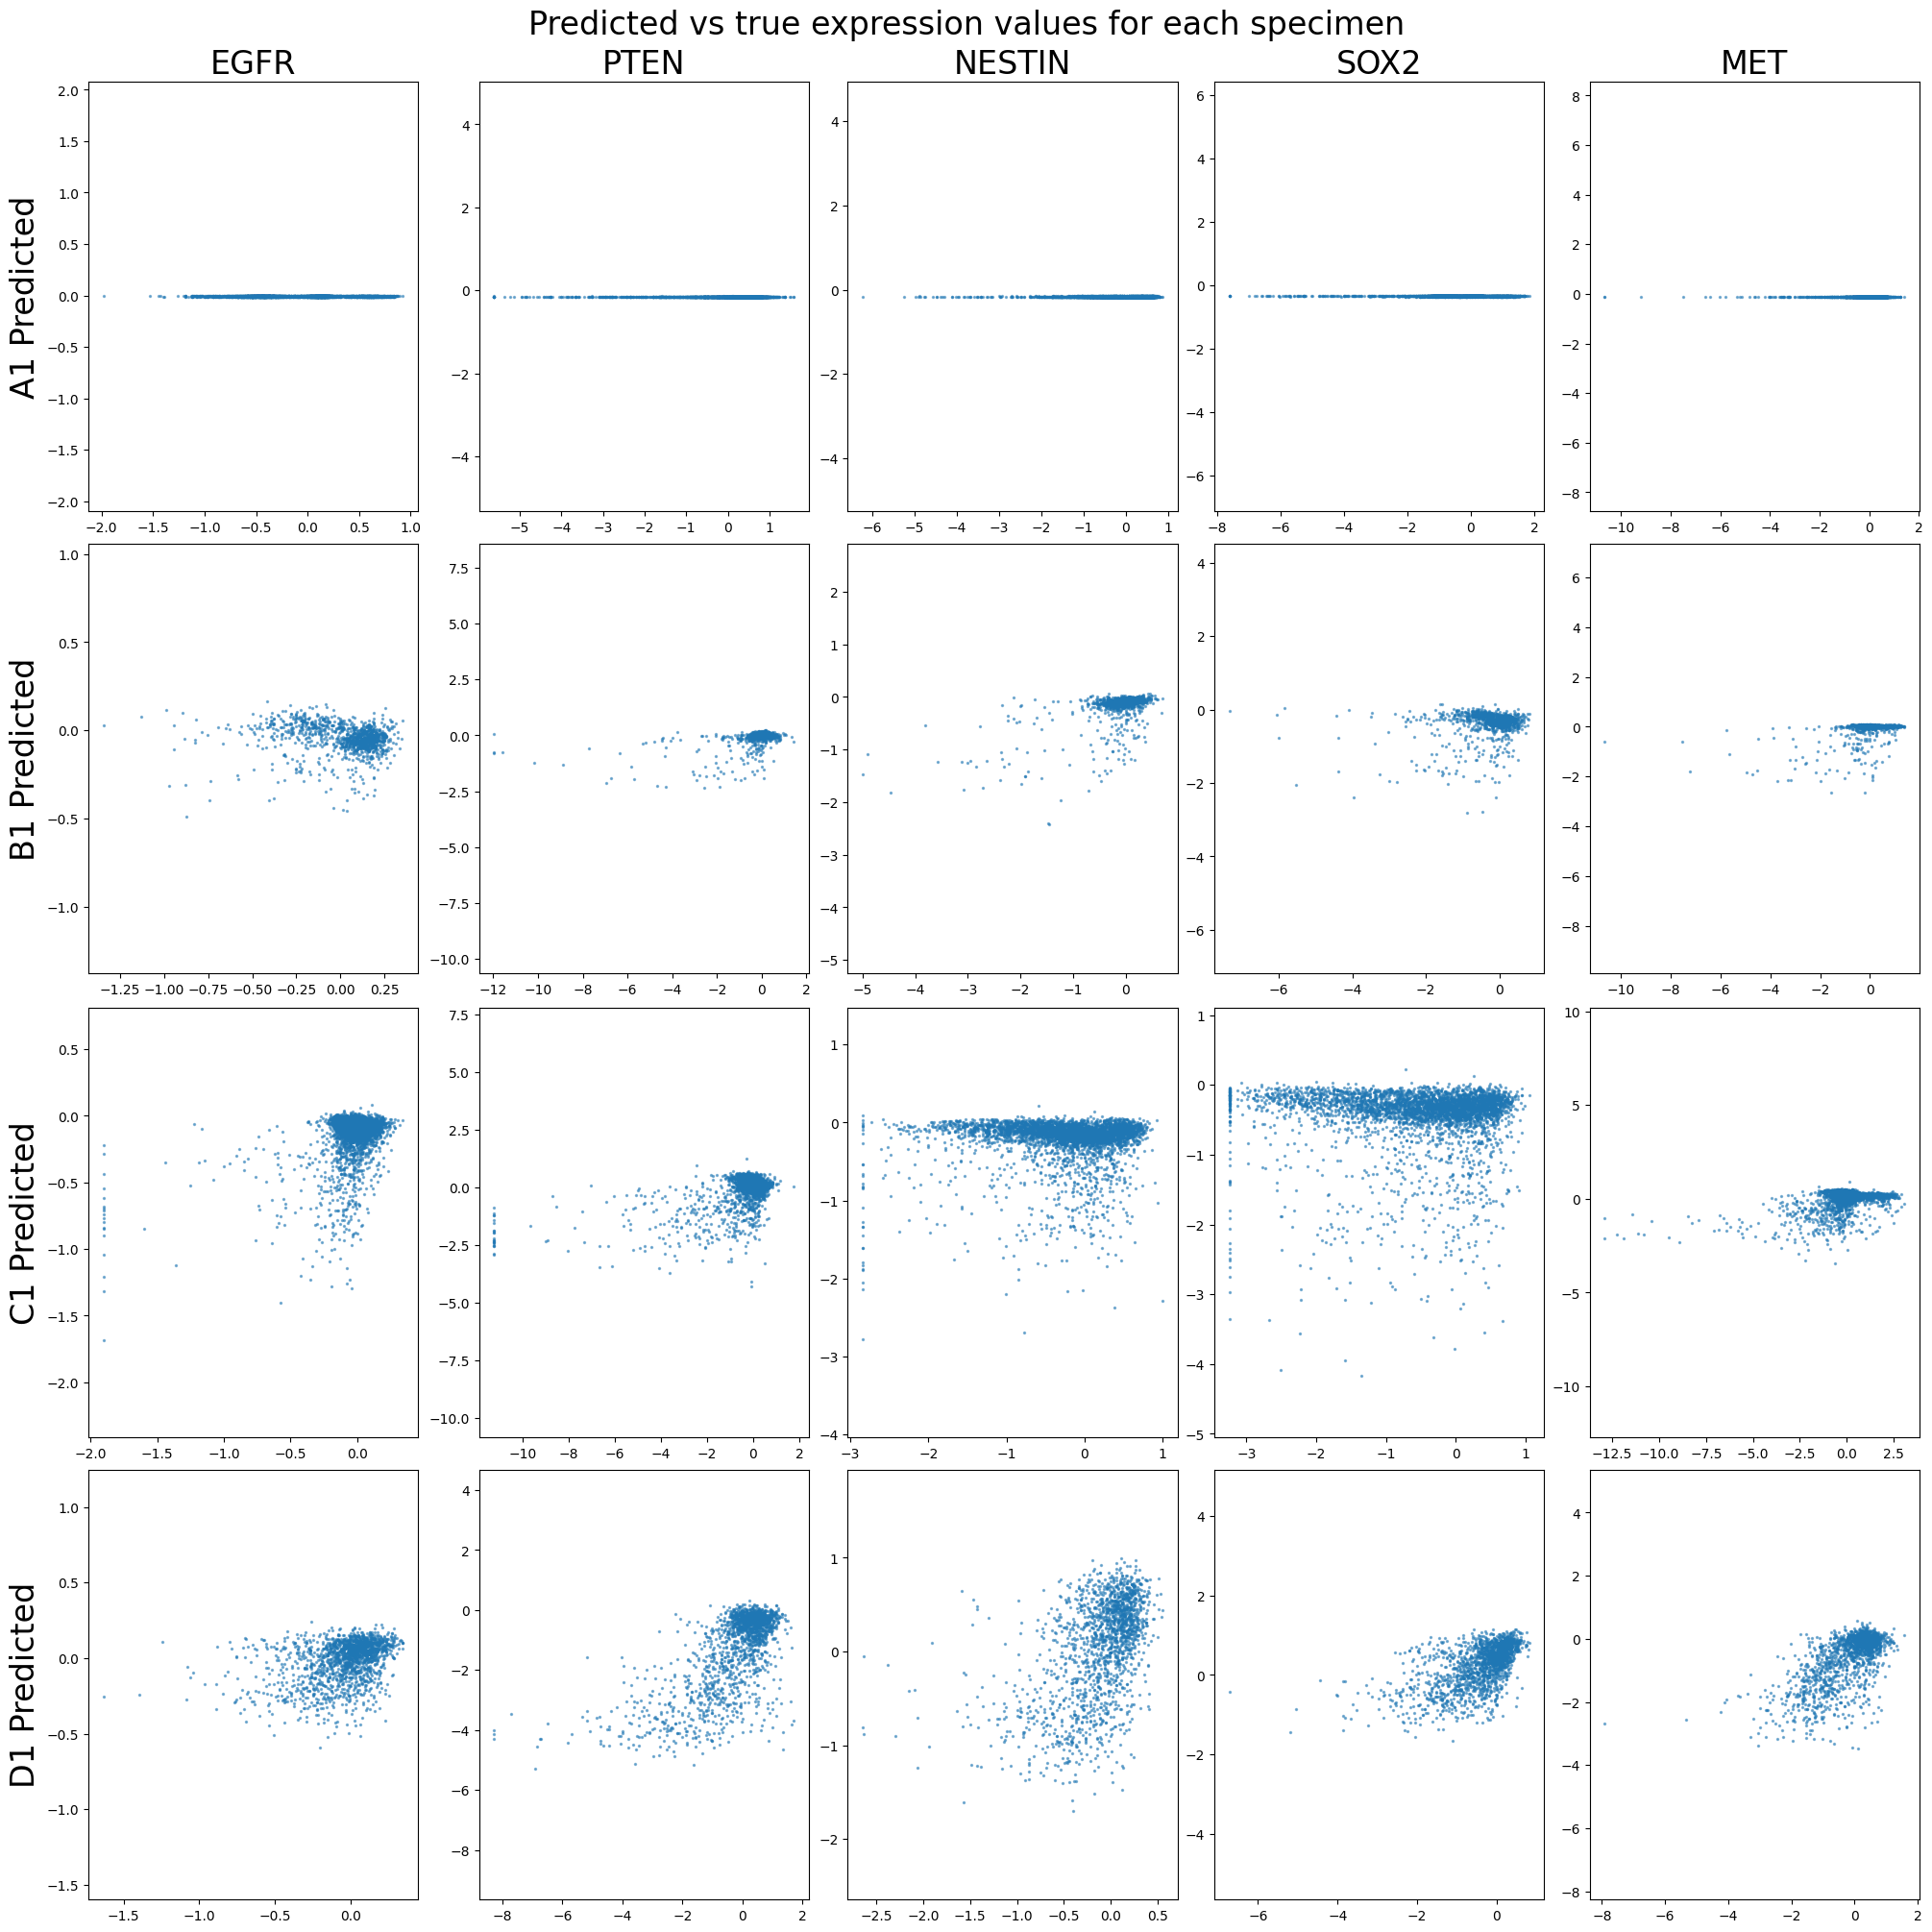

In [62]:
fig, axs = plt.subplots(4, 5, figsize=(20, 20), layout="constrained")
specimen_ids = sorted([split[0] for split in splits])
full_predicted_labels = {specimen_id: [] for specimen_id in specimen_ids}
full_true_labels = {specimen_id: [] for specimen_id in specimen_ids}

for specimen_id, train_idxs, val_idxs in splits:
    val_image_dataset_split = torch.utils.data.Subset(image_dataset, val_idxs)
    val_image_dataloader = torch.utils.data.DataLoader(val_image_dataset_split, batch_size=32, shuffle=False)
    
    model = get_checkpoint("convnetcombine", f"regression_spec_{specimen_id}")
    model.eval()
    
    predicted_labels = []
    true_labels = []
    with torch.no_grad():
        for i, data in enumerate(val_image_dataloader):
            inputs, labels = data
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            predicted_labels.append(outputs.cpu().numpy())
            true_labels.append(labels.cpu().numpy())
            
    predicted_labels = np.concatenate(predicted_labels)
    true_labels = np.concatenate(true_labels)
    
    full_predicted_labels[specimen_id].append(predicted_labels)
    full_true_labels[specimen_id].append(true_labels)
    
    for i in range(5):
        ax = axs[specimen_ids.index(specimen_id), i]
        ax.scatter(true_labels[:, i], predicted_labels[:, i], alpha=0.5, s=2)
        ax.axis("equal")
        if i == 0:
            ax.set_ylabel(f"{specimen_id} Predicted", fontsize=24)
        if specimen_ids.index(specimen_id) == 0:
            ax.set_title(f"{image_dataset.label_columns[i]}", fontsize=24)
            
full_predicted_labels = {k: np.concatenate(v) for k, v in full_predicted_labels.items()}
full_true_labels = {k: np.concatenate(v) for k, v in full_true_labels.items()}
fig.suptitle("Predicted vs true expression values for each specimen", fontsize=24)
        

In [49]:
full_metrics = {label: [get_regression_metrics(full_predicted_labels[specimen_id][:, i], full_true_labels[specimen_id][:, i]) for specimen_id in specimen_ids] for i, label in enumerate(image_dataset.label_columns)}

In [59]:
for label, metrics in full_metrics.items():
    metrics = pd.DataFrame(metrics, index=specimen_ids)
    mean = metrics.mean()
    std = metrics.std()
    print(f"Metrics for {label}:")
    for metric in metrics.columns:
        print(f"   {metric}: {mean[metric]:.5f} ± {std[metric]:.5f}")

Metrics for EGFR:
   RMSE: 0.27162 ± 0.12565
   Pearson: 0.22309 ± 0.16007
   Spearman: 0.14908 ± 0.27029
   R2 score: -0.03097 ± 0.09641
Metrics for PTEN:
   RMSE: 1.04836 ± 0.07664
   Pearson: 0.41404 ± 0.27421
   Spearman: 0.23894 ± 0.28287
   R2 score: 0.13957 ± 0.16502
Metrics for NESTIN:
   RMSE: 0.62967 ± 0.15976
   Pearson: 0.09467 ± 0.24688
   Spearman: 0.02635 ± 0.26460
   R2 score: -0.12132 ± 0.15785
Metrics for SOX2:
   RMSE: 0.92732 ± 0.24401
   Pearson: 0.08665 ± 0.38632
   Spearman: 0.07412 ± 0.43141
   R2 score: 0.02713 ± 0.17771
Metrics for MET:
   RMSE: 0.84664 ± 0.10385
   Pearson: 0.32975 ± 0.30814
   Spearman: 0.21635 ± 0.28444
   R2 score: 0.09459 ± 0.11437


The final results for the Combined convolutional neural network are unsatisfactory. There is clearly some good fitting happening for some of the proteins but overall, its is not fitting well. 

For NESTIN, the best predictor is still the SVM trained on various hand crafted features detailed above.

In [66]:
full_metrics_nestin = pd.DataFrame(full_metrics["NESTIN"], index=specimen_ids)
full_metrics_nestin = full_metrics_nestin.mean()

In [68]:
all_metrics = pd.DataFrame([svr_metrics, mlp_metrics, convnet_metrics, full_metrics_nestin], index=["SVR", "MLP", "ConvNet", "4-fold ConvNet"])

In [69]:
all_metrics

RMSE   Pearson  Spearman  R2 score
SVR             0.447506  0.743340  0.778444  0.544917
MLP             0.491842  0.690134  0.693098  0.450276
ConvNet         0.469817  0.052446 -0.026782 -0.157367
4-fold ConvNet  0.629672  0.094666  0.026346 -0.121319

There may be some improvements to this training pipeline. Firstly we can augment the training set with translated images. There may be a case for transfer learning here, with a pretrained model that can detect pertinent features. The simple models used might be computationally efficient but they might not capture the nuances in the data. 

We could try to use ensemble methods like a random forest regressor.

We can apply better regularisation with explicit regularisation like L1 and L2 reg.